In [13]:
%load_ext autoreload
%autoreload 2

In [39]:
#!uv add scipy
#!uv add matplotlib
!uv add rich

Resolved 120 packages in 1.31s                                       
Prepared 3 packages in 224ms                                             
Installed 3 packages in 76ms                                
 + markdown-it-py==4.0.0
 + mdurl==0.1.2
 + rich==14.1.0


In [40]:
import pyaudio
print(pyaudio.__version__)

0.2.14


In [41]:
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

print(sd.query_devices())

   0 bcm2835 Headphones: - (hw:0,0), ALSA (0 in, 8 out)
   1 seeed-2mic-voicecard: bcm2835-i2s-wm8960-hifi wm8960-hifi-0 (hw:2,0), ALSA (2 in, 2 out)
   2 sysdefault, ALSA (0 in, 128 out)
   3 lavrate, ALSA (0 in, 128 out)
   4 samplerate, ALSA (0 in, 128 out)
   5 speexrate, ALSA (0 in, 128 out)
   6 speex, ALSA (0 in, 1 out)
   7 upmix, ALSA (0 in, 8 out)
   8 vdownmix, ALSA (0 in, 6 out)
   9 playback, ALSA (0 in, 128 out)
  10 capture, ALSA (128 in, 0 out)
  11 dmixed, ALSA (0 in, 2 out)
  12 array, ALSA (2 in, 0 out)
  13 dmix, ALSA (0 in, 2 out)
* 14 default, ALSA (128 in, 128 out)


In [42]:
DEVICE = "seeed-2mic-voicecard"
audio_file = "output_2.wav"

In [44]:
# Record 5 seconds of audio
duration = 10  
samplerate = 48000  # matches openWakeWord default
recording = sd.rec(int(duration * samplerate), 
                   samplerate=samplerate, 
                   channels=1, 
                   dtype='int16', 
                   device=DEVICE)
sd.wait()

print("Recorded shape:", recording.shape)

Recorded shape: (480000, 1)


In [46]:
# Play back the recorded audio
sd.play(recording, samplerate=samplerate, device=DEVICE)
sd.wait()
write(audio_file,samplerate, recording)
print(f"Saved as {audio_file}")

Saved as output_2.wav


In [47]:
!ls -lah

total 1.9M
drwxr-xr-x 3 rsilveira79 rsilveira79 4.0K Sep  5 17:12 .
drwxr-xr-x 5 rsilveira79 rsilveira79 4.0K Sep  5 16:41 ..
-rw-r--r-- 1 rsilveira79 rsilveira79  49K Sep  5 17:12 0.test_audio.ipynb
drwxr-xr-x 2 rsilveira79 rsilveira79 4.0K Sep  5 16:56 .ipynb_checkpoints
-rw-r--r-- 1 rsilveira79 rsilveira79 938K Sep  5 17:12 output_2.wav
-rw-r--r-- 1 rsilveira79 rsilveira79 938K Sep  5 17:10 output.wav


In [48]:
## Plot audio 

In [49]:
audio_data = recording.flatten()
time = np.arange(audio_data.shape[0]) / samplerate

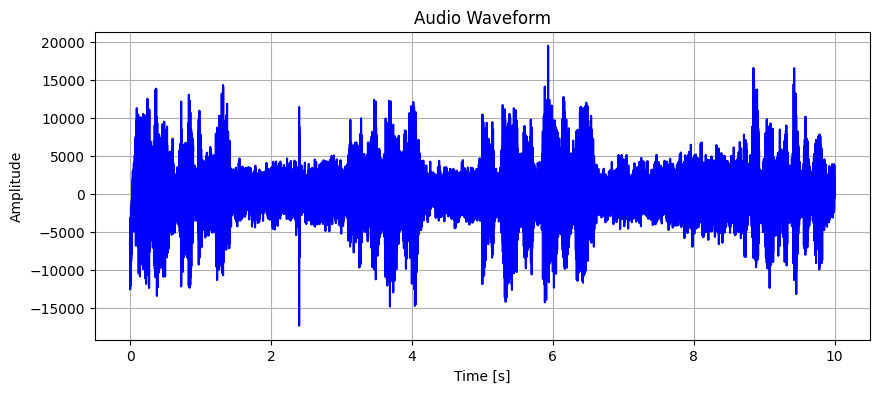

In [50]:
# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data, color='blue')
plt.title("Audio Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Check Sample Rates

In [7]:
device_index = 1  # change to your mic index from sd.query_devices()

## Check Sample Rates
for rate in [8000, 16000, 22050, 44100, 48000]:
    try:
        sd.check_input_settings(device=device_index, samplerate=rate, channels=1)
        print(f"✅ Supported: {rate} Hz")
    except Exception as e:
        print(f"❌ Not supported: {rate} Hz -> {e}")

✅ Supported: 8000 Hz
✅ Supported: 16000 Hz
✅ Supported: 22050 Hz
✅ Supported: 44100 Hz
✅ Supported: 48000 Hz
